# Pre-Post Statistical Test
This test compares two states of the samples: before and after an intervention or treatment has been applied.

In [3]:
!pip install pingouin

In [34]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pingouin as pg

# Dataset
Let's start by creating a dataset for this test.

* **Scenario**: Our client is a grocery store that is implementing a new initiative. Our task as data scientists is to assess if this initiative is making any impact in sales after the implementation.

In [5]:
# Date
dates = pd.date_range(start='2024-01-01', end='2024-01-30')

# Stores IDs
store_ids = range(1,1001,1)

# Control and Treat Group
np.random.seed(42)
group = np.random.choice(a=['Control', 'Treatment'], size=len(store_ids), p=[0.50, 0.50])

# Create dataframe
df = pd.DataFrame({'dt': list(dates)*1000,'store_id': list(store_ids)*30, 'group':list(group)*30})

# Sales Control and Treatment
sales_control = np.random.normal(loc=100, scale=20, size=len(df[df['group'] == 'Control']))
sales_treatment_before = np.random.normal(loc=100, scale=20, size=len(df[(df.group == 'Treatment') & (df.dt <= '2024-01-15')]) )
sales_treatment_after = np.random.normal(loc=104, scale=10, size=len(df[(df.group == "Treatment") & (df.dt > "2024-01-15")]))

# Add sales to the data
df = df.sort_values(['group', 'dt'])
df['sales'] = np.concatenate([sales_control, sales_treatment_before, sales_treatment_after])
df = df.sort_values(['dt', 'store_id'])

# View Dataset
df.sample(8).sort_values('dt')

,dt,store_id,group,sales
1112,2024-01-03,113,Treatment,93.022960
23432,2024-01-03,433,Treatment,128.985849
27555,2024-01-16,556,Control,85.306578
619,2024-01-20,620,Treatment,115.289692
4012,2024-01-23,13,Treatment,109.965434
7494,2024-01-25,495,Control,78.300640
1794,2024-01-25,795,Control,93.938146
9898,2024-01-29,899,Control,83.073060


In [6]:
# Check how many stores in each group
df.groupby('group').store_id.nunique()

group
Control      503
Treatment    497
Name: store_id, dtype: int64

# Power of test
Find the size of the sample

In [ ]:
from statsmodels.stats.power import TTestIndPower

In [ ]:
# Parameter for the power analysis
effect = 0.2 # effect size must be positive
alpha = 0.05
power = 0.8

# Perform power analysis
pwr = TTestIndPower()

result = pwr.solve_power(effect, power = power, nobs1= None, ratio = 1, alpha=alpha)

print(result)

393.4056989990335


# Preparing the Data

In [12]:
# Difference between groups
df.groupby('group')[["sales"]].mean()

,sales
group,
Control,100.032725
Treatment,102.014091


In [13]:
# split between Pre and Post periods
df['after'] = np.where(df['dt'] > '2024-01-15', 1, 0)

# pre_post data
df_pre_post = (df # dataset
               .groupby(['store_id','group','after']) # groupings
               .sales.mean() # calculate sales means
               .reset_index()
               .pivot(index=['store_id', 'group'], columns='after', values='sales') # pivot the data to put pre and post in columns
               .reset_index()
               .rename(columns={0:'pre', 1:'post'}) # rename
               )

# create col difference post-pre
df_pre_post = df_pre_post.assign(dif_pp= df_pre_post.post - df_pre_post.pre)

# View
df_pre_post

after,store_id,group,pre,post,dif_pp
0,1,Control,98.146780,108.272529,10.125749
1,2,Treatment,103.114093,100.591466,-2.522627
2,3,Treatment,106.356929,103.304819,-3.052110
3,4,Treatment,89.385473,107.779255,18.393783
4,5,Control,97.796140,94.102268,-3.693872
...,...,...,...,...,...
995,996,Control,100.869328,106.314343,5.445015
996,997,Treatment,94.272504,103.636073,9.363569
997,998,Control,100.946510,100.132046,-0.814464
998,999,Treatment,108.944623,107.358913,-1.585711


In [14]:
# Pre and Post periods means
df_pre_post.groupby('group')[['pre', 'post']].mean()

after,pre,post
group,,
Control,99.797720,100.132259
Treatment,99.986935,103.971701


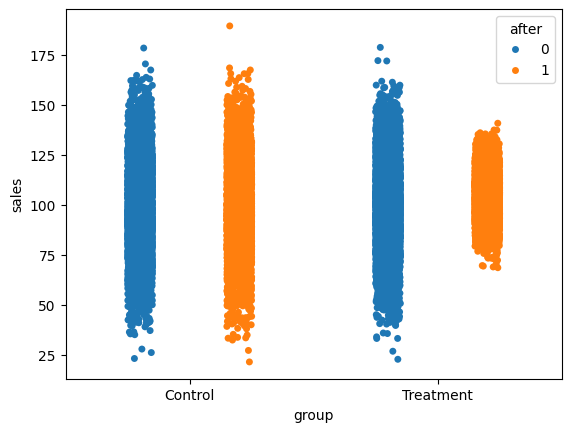

In [15]:
# Visualization
plot = df.assign(after= np.where(df['dt'] > '2024-01-15', 1, 0))
sns.stripplot(x='group', y='sales', hue= 'after', dodge= True, data=plot);

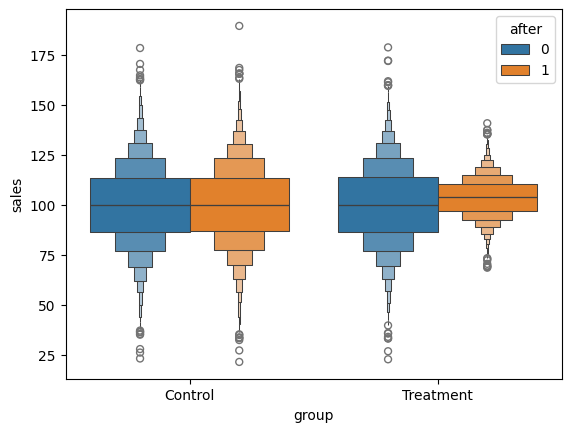

In [16]:
# BoxenPlot
sns.boxenplot(x='group', y='sales', hue= 'after', data=plot);

# Pre Post Test

### Levene's Test

In [17]:
# Checking for equal variances of the samples (Pre and Post)
# This can be done with Levene's test.
def levene_test(data, value_var, category_var):
    return pg.homoscedasticity(data, dv=value_var,
                               group=category_var,
                               method='levene', alpha=0.05)


In [18]:
# Perform Levene's test
levene_test(df_pre_post, 'dif_pp', 'group')

,W,pval,equal_var
levene,18.701305,0.000017,False


Next, we should check if the difference found between groups means is statistically significant.
For a Pre-Post test with only two groups, we can use:
* Two sample paired test if the distribution is normal
* Wilcoxon test if not normal

### Normality (Shapiro) and T-Test

In [19]:
# Let's test for normality of the distributions of Pre and Post periods.
# Ho = Data is normally distributed

print(scs.shapiro(df_pre_post.query('group == "Control"')['pre']))
print(scs.shapiro(df_pre_post.query('group == "Control"')['post']))
print(scs.shapiro(df_pre_post.query('group == "Treatment"')['pre']))
print(scs.shapiro(df_pre_post.query('group == "Treatment"')['post'])) # This last one the p-value is 0.03. It's close enough to the alpha value, but it is not normal.

ShapiroResult(statistic=0.9967775344848633, pvalue=0.41802579164505005)
ShapiroResult(statistic=0.9979024529457092, pvalue=0.7954561114311218)
ShapiroResult(statistic=0.9956731796264648, pvalue=0.1869998276233673)
ShapiroResult(statistic=0.9935430884361267, pvalue=0.032079797238111496)


In [20]:
# Paired 2 sample test
# This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
print(scs.ttest_rel(df_pre_post.query('group == "Control"')['pre'], df_pre_post.query('group == "Control"')['post']))
print(scs.ttest_rel(df_pre_post.query('group == "Treatment"')['pre'], df_pre_post.query('group == "Treatment"')['post']))

# Running Wilcoxon for the Not Normal sample
print(scs.wilcoxon(df_pre_post.query('group == "Treatment"')['pre'], df_pre_post.query('group == "Treatment"')['post']))

TtestResult(statistic=-0.9901946209840918, pvalue=0.3225560292205154, df=502)
TtestResult(statistic=-14.576067836748276, pvalue=2.5969980216983843e-40, df=496)
WilcoxonResult(statistic=21562.0, pvalue=2.544753810592371e-36)


## Pairwise Comparison of the Difference in Difference

We can use Tukey's test for equal variances
Use Games-Howell for Unequal variances (our case)

* *Difference in Difference (DiD)*: Since there is a difference between **Test and Control** and also a difference **Before and After**, if we want to isolate the real change effect, we can calculate the difference between Before vs After and then make the comparison of that difference in both samples, like a regular A/B test.

In [ ]:
# Creating a function for this test
def games_howell(data, value_var, category_var):
    return pg.pairwise_gameshowell(data=data, dv=value_var,
                        between=category_var).round(2)

In [ ]:
games_howell(df_pre_post, 'dif_pp', 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Treatment,0.33,3.98,-3.65,0.43,-8.4,958.64,0.0,-0.53


In [ ]:
# create 95% confidence interval for the Test
scs.norm(loc=3.65, scale=0.43).interval(confidence= 0.95)

(2.8072154866477765, 4.492784513352223)

In [ ]:
df_pre_post.to_csv('pre_post.csv')

## Test versus Control Difference Check
Since we already isolated the effect of the Before and After effect, let's now isolate the Test versus Control, by calculating the Differences in the distributions of both samples.

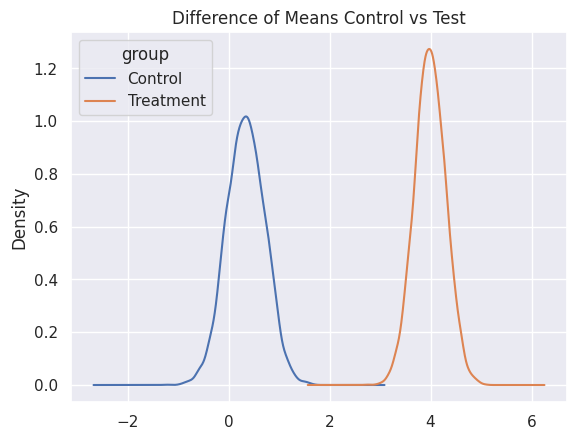

In [38]:
# Let's simulate 5000 times a Control versus a Test sample.

# We can Bootstrap
boot_means = []

# Simulation N times
N = 5_000
for i in range(N):
  # take 400 stores from each group
  control = df_pre_post.query('group == "Control"').sample(n=400, replace=True)
  test =  df_pre_post.query('group == "Treatment"').sample(n=400, replace=True)
  final_data = pd.concat([control, test])

  # shuffle
  boot_sample = (
      final_data
      .groupby('group')['dif_pp']
      .mean()
      )
  #append
  boot_means.append(boot_sample)

# To Dataframe
boot_means = pd.DataFrame(boot_means)

# kde plot
boot_means.plot(kind='kde')
plt.title('Difference of Means Control vs Test');

Another way of performing the same test is using the Sample mean and Standard Deviation to create a normal curve. This is the same as simulate 10k times with Bootstrap.

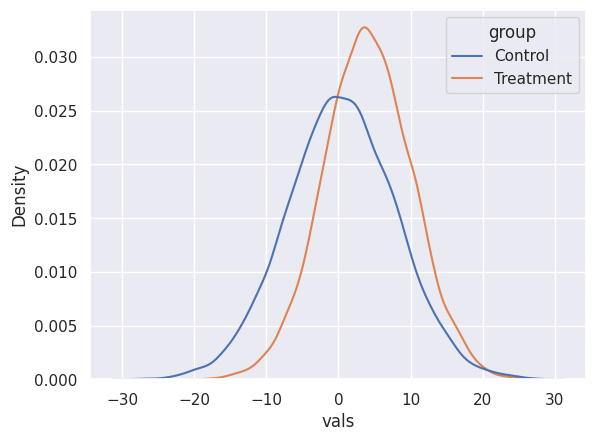

In [78]:
# Collecting Mean and Standard Deviation of the samples
sample_means = (
    df_pre_post
    .groupby('group')
    .agg({'dif_pp' : ['mean', 'std']})
    .reset_index()
)

# Rename cols
sample_means.columns = ['group', 'mean', 'std']

# Get Mean and Std
mean_control = sample_means.query('group == "Control"')['mean'].values[0]
std_control = sample_means.query('group == "Control"')['std'].values[0]

mean_treatment = sample_means.query('group == "Treatment"')['mean'].values[0]
std_treatment = sample_means.query('group == "Treatment"')['std'].values[0]

N= 10_000
# Plot data
plot = pd.DataFrame({'group': np.repeat(['Control', 'Treatment'], N),
                     'vals': np.concatenate([np.random.normal(loc=mean_control, scale=std_control, size=N),
                                             np.random.normal(loc=mean_treatment, scale=std_treatment, size=N)])   })
# Plot
sns.kdeplot(data=plot, x='vals', hue='group');


95% Confidence Interval


(2.798422817822547, 4.502031904926034)

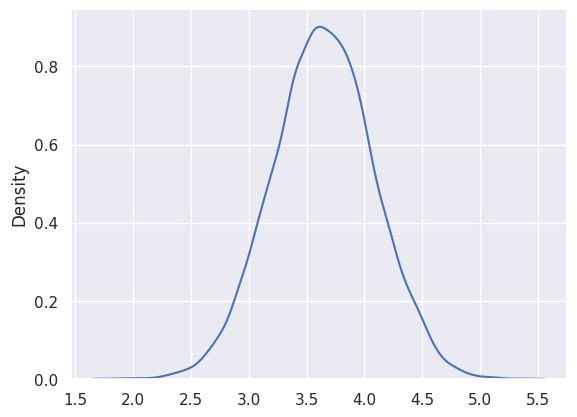

In [93]:
N= 10_000
# Plot parameters
nA = df_pre_post.query('group == "Control"').shape[0]
nB = df_pre_post.query('group == "Treatment"').shape[0]
dif_mu = df_pre_post.groupby('group').dif_pp.mean()[1] - df_pre_post.groupby('group').dif_pp.mean()[0] # [mean diff post] - [mean diff pre]
dif_std = np.sqrt( ((std_control**2) / nA ) + ( (std_treatment**2) / nB) )

# Plot
sns.kdeplot( np.random.normal(loc= dif_mu,
                              scale= dif_std,
                              size=N) );

print('95% Confidence Interval')
scs.norm(loc= dif_mu, scale= dif_std).interval(confidence= 0.95)

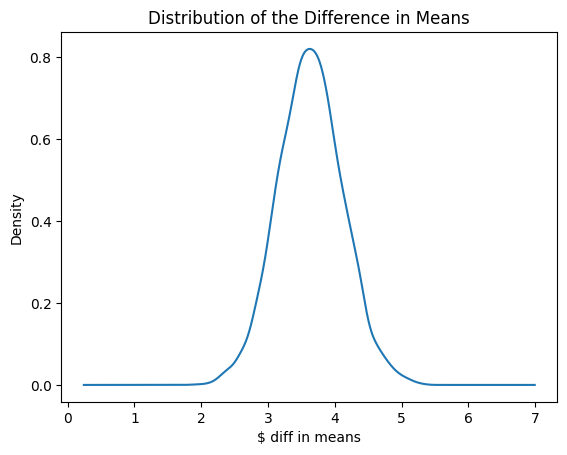

In [ ]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['test_control_diff'] = (boot_means['Treatment'] - boot_means['Control'])

# plot the bootstrap sample difference
ax = boot_means['test_control_diff'].plot(kind = 'kde')
ax.set_xlabel("$ diff in means")
plt.title('Distribution of the Difference in Means');

In [ ]:
b_mu = boot_means.test_control_diff.mean()
b_std = boot_means.test_control_diff.std()
point_estimate = 0 # my test

# Calculating Z score = "point_estimate - mean/std"
Z = (point_estimate - b_mu)/b_std

# Use the cumulative distribution function (CDF) to find the probability
probability = scs.norm.cdf(Z)

print("Probability of a number being below 0:", probability)

Probability of a number being below 0: 3.364165496641146e-14


In [ ]:
# create 95% confidence interval for the Test
scs.norm(loc=b_mu, scale=b_std).interval(confidence= 0.95)

(2.684772291124058, 4.586800294187557)